In [132]:
import torch
from torch import nn
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pickle
import os

In [4]:
# Set model target device (mps for GPU on apple devices)
device = torch.device('mps')

'2.0.1'

# Create data

In [105]:
weights = 0.7
bias = 0.3

# Make up vars 
start = 0
end = 1
step = 0.02
# unsqueeze(dim=1): Returns a new tensor with a dimension of size one inserted at the specified position
X = torch.arange(start, end, step, device='mps').unsqueeze(dim=1)
y = weights * X + bias

len(X), len(y)

(50, 50)

In [106]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [112]:
def plot_predictions(
        train_data=X_train.to(torch.device('cpu')),
        train_labels=y_train.to(torch.device('cpu')),
        test_data=X_test.to(torch.device('cpu')),
        test_labels=y_test.to(torch.device('cpu')),
        predictions=None):
    """
    Plot and compare predictions
    """
    plt.figure(figsize=(10,7))

    # Plot scatters: Train data
    plt.scatter(train_data, train_labels, c='b', s=4, label='Training data')
    # Plot scatters: Test data
    plt.scatter(test_data, test_labels, c='g', s=4, label='Test data')
    # Plot scatters: Predictions
    if predictions is not None:
        plt.scatter(test_data, predictions, c='r', s=4, label='Predictions')
    
    # Show legend
    plt.legend(prop={'size':14});

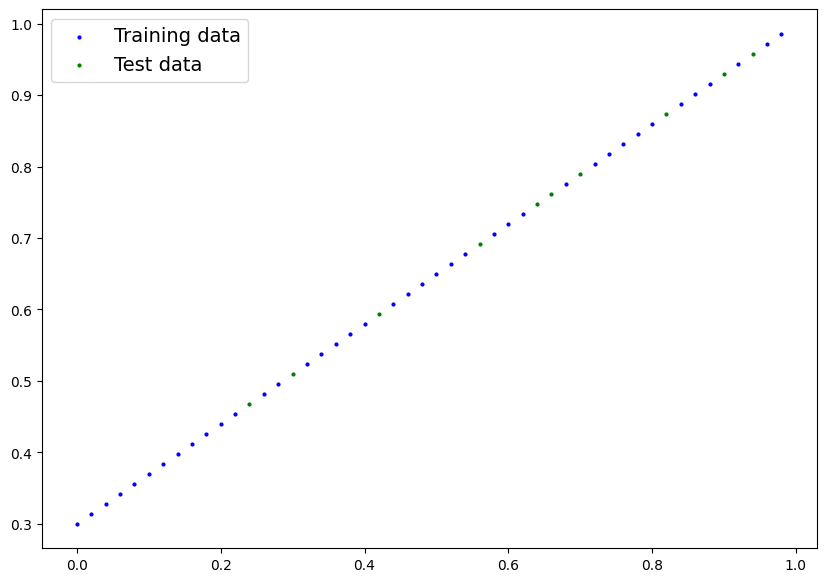

In [113]:
plot_predictions()

# Setup model config

> torch.rand(): Returns a tensor filled with random numbers from a uniform distribution on the interval [0,1)   
> torch.rand().requires_grad : If autograd should record operations on the returned tensor

In [47]:
# Create a class for a linear model (Large version)
class LinearRegressionModel(nn.Module): # All pytorch models inherit from nn.Module
    # Constructor to Inicialize parameters
    def __init__(self): 
        # Initialize parent class parameters
        super().__init__()
        # Initialize model parameters
        self.weights = nn.Parameter(torch.rand(1, requires_grad=True, dtype=torch.float))
        self.bias = nn.Parameter(torch.rand(1, requires_grad=True, dtype=torch.float))

    # forward() method to compute the model
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.weights * x + self.bias  # Lineal regression function

In [100]:
# Create a class for a linear model (Pytorch version)
class LinearRegressionModel(nn.Module): # All pytorch models inherit from nn.Module
    # Constructor to Inicialize parameters
    def __init__(self):
        # Initialize parent class parameters
        super().__init__()
        # Initialize model parameters: https://pytorch.org/docs/stable/generated/torch.nn.Linear.html
        self.linear_layer = nn.Linear(in_features=1, out_features=1)

    # forward() method to compute the model
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.linear_layer(x)  # Lineal regression function

In [101]:
# Set seed for reproducibility
torch.manual_seed(42) 
# Instanciate and Initialize model class
model1 = LinearRegressionModel()
model1, model1.state_dict()

(LinearRegressionModel(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
              ('linear_layer.bias', tensor([0.8300]))]))

In [102]:
model1.to(device)
next(model1.parameters()).device

device(type='mps', index=0)

# Training model

For training we need:
* Loss function
* Optimizer
* Training loop
* Testing loop

In [103]:
# Setup Loss function: 
# nn.L1Loss(): Creates a criterion that measures the mean absolute error (MAE) between each element in the input x and target y
loss_fn = nn.L1Loss()

# Setup optimizer
# torch.optim.SGD(): Implements stochastic gradient descent
optimizer = torch.optim.SGD(params=model1.parameters(), lr=0.01, )

In [110]:
# Training loop
torch.manual_seed(42) 

epochs = 200

for epoch in range(epochs):

    # ==================================================================TRAINING==================================================================

    # model1.train() (Bool): Set the object in training mode: 
    # This has any effect only on certain modules. See documentations of particular modules for details of their behaviors in training/evaluation mode,
    # if they are affected, e.g. Dropout, BatchNorm, etc.
    model1.train()

    # 1. Forward pass: Apply linear regression formula
    y_pred = model1(X_train)

    # 2. Calculate the loss: MAE over predictions and labels
    loss = loss_fn(y_pred, y_train)

    # 3. Optimizer zero grad: Sets the gradients of all optimized torch.Tensor s to zero.
    optimizer.zero_grad()

    # 4. Backwards pass: Performs backwards propagation
    loss.backward()

    # 5. Optimizer step: Update optimizer values
    optimizer.step()

    # ==================================================================TESTING==================================================================

    # model1.eval() (Bool): Set the object in evaluation mode:
    # This has any effect only on certain modules. See documentations of particular modules for details of their behaviors in training/evaluation mode,
    # if they are affected, e.g. Dropout, BatchNorm, etc.
    model1.eval()

    with torch.inference_mode():
        test_pred = model1(X_test)
        test_loss = loss_fn(test_pred, y_test)

    # Print out what's happening
    if epoch % 10 == 0:
        print(f'Epoch: {epoch} | Loss: {loss} | Test loss: {test_loss}')

/Users/andresg/Documents/PyTorch-Walkthrough/venv/lib/python3.9/site-packages/torch/autograd/__init__.py:200: UserWarning: The operator 'aten::sgn.out' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/mps/MPSFallback.mm:11.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch: 0 | Loss: 0.5595665574073792 | Test loss: 0.5570623278617859
Epoch: 10 | Loss: 0.4385901391506195 | Test loss: 0.4287578761577606
Epoch: 20 | Loss: 0.31761375069618225 | Test loss: 0.30045342445373535
Epoch: 30 | Loss: 0.196637362241745 | Test loss: 0.17214898765087128
Epoch: 40 | Loss: 0.07566095888614655 | Test loss: 0.043844547122716904
Epoch: 50 | Loss: 0.034644510596990585 | Test loss: 0.026423484086990356
Epoch: 60 | Loss: 0.028627431020140648 | Test loss: 0.025040650740265846
Epoch: 70 | Loss: 0.0233838502317667 | Test loss: 0.020264996215701103
Epoch: 80 | Loss: 0.018141767010092735 | Test loss: 0.015795880928635597
Epoch: 90 | Loss: 0.012898189015686512 | Test loss: 0.011020240373909473
Epoch: 100 | Loss: 0.007656102068722248 | Test loss: 0.006551099009811878
Epoch: 110 | Loss: 0.002556838095188141 | Test loss: 0.0031962753273546696
Epoch: 120 | Loss: 0.003946700133383274 | Test loss: 0.009604135528206825
Epoch: 130 | Loss: 0.003946700133383274 | Test loss: 0.0096041355

In [114]:
model1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.6955]], device='mps:0')),
             ('linear_layer.bias', tensor([0.3060], device='mps:0'))])

# Make evaluations and predictions

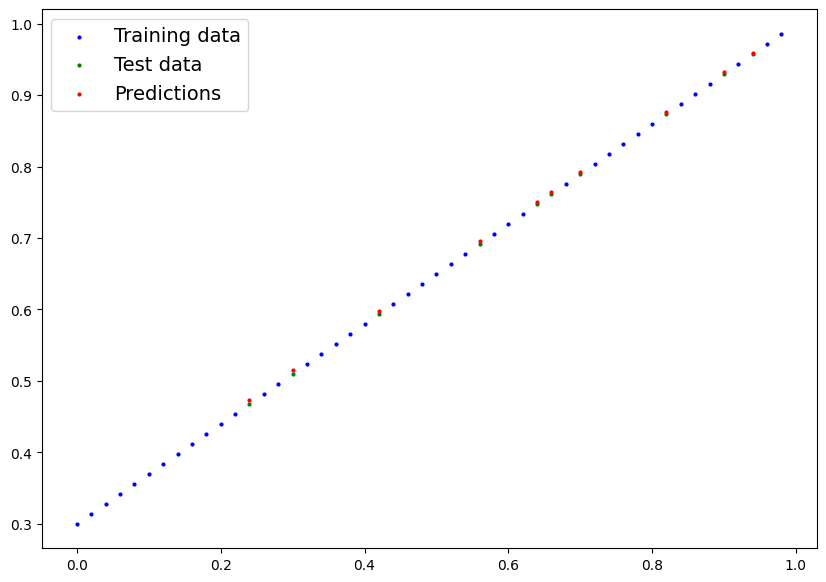

In [128]:
# Turn model into evaluation mode
model1.eval()

# Evaluations
with torch.inference_mode():
    y_pred = model1(X_test).cpu() # Convert to cpu to plot in Numpy arrays

# Plot predictions
plot_predictions(predictions = y_pred)

# Saving the trained model

In [159]:
# Set folder and model name
folder_name = 'models'
model_name = 'LinearRegressionModel.pth'

# .pth: typically contains a serialized PyTorch state dictionary that contains the state of a PyTorch model, including the model's weights, biases, 
# and other parameters.

# Create folder if does not exist
if not os.path.exists(folder_name):
    os.mkdir(folder_name)

# Define path and save model state parameters
model_path = os.path.join(folder_name, model_name)
torch.save(obj=model1.state_dict(), f=model_path)

# Loading the trained model

In [161]:
# Load the pytorch model

# Create a new instance of the model
load_model1 = LinearRegressionModel()

# Load model state
state_dict = torch.load(model_path)

# Update model parameters
load_model1.load_state_dict(state_dict)

# Put the loaded model to device (mps)
load_model1.to(device)

LinearRegressionModel(
  (linear_layer): Linear(in_features=1, out_features=1, bias=True)
)

In [164]:
next(load_model1.parameters()).device

device(type='mps', index=0)